In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from sklearn import model_selection, preprocessing, metrics
import xgboost as xgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999


from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
def load_df(csv_path='data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [4]:
%%time
train_df = load_df()
test_df = load_df("data/test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 4min 7s, sys: 9.24 s, total: 4min 16s
Wall time: 4min 2s


In [5]:
train = train_df
test = test_df

In [6]:
train['date'] = train.date.apply(str)

In [7]:
train['date'] = train['date'].str[:4] + '-' + train['date'].str[4:6] + '-' + train['date'].str[6:8]

In [8]:
add_datepart(train, "date", drop=False)
add_datepart(test, "date", drop=False)

In [9]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

In [10]:
print("Variables not in test but in train : ", set(train.columns).difference(set(test.columns)))

Variables not in test but in train :  {'trafficSource.campaignCode', 'totals.transactionRevenue'}


In [11]:
# Columns with constant values
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1]
cols_to_drop = const_cols + ['sessionId'] 

train = train.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test = test.drop(cols_to_drop, axis=1)

In [12]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.deviceCategory',
       'device.isMobile', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source', 'Year', 'Month', 'Week', 'Day', 'Dayofweek',
       '

In [13]:
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect',
            'Year', 'Month', 'Week', 'Day', 'Dayofweek',
            'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
            'Is_quarter_start', 'Is_year_end', 'Is_year_start'
           ]

num_cols = ["totals.hits", "totals.pageviews", "visitNumber", 
            "visitStartTime", 'totals.bounces',  'totals.newVisits']

In [14]:
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect
Year
Month
Week
Day
Dayofweek
Dayofyear
Is_month_end
Is_month_start
Is_quarter_end
Is_quarter_start
Is_year_end
Is_year_start


In [15]:
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

In [16]:
for v in cat_cols: train[v] = train[v].astype('category').cat.as_ordered()

In [19]:
for v in num_cols:
    train[v] = train[v].fillna(0).astype('float32')
    test[v] = test[v].fillna(0).astype('float32')
train['totals.transactionRevenue'] = train['totals.transactionRevenue'].fillna(0).astype('float32')

In [18]:
apply_cats(test, train)

In [20]:
train = train[cat_cols + num_cols + ['totals.transactionRevenue']]
test = test[cat_cols + num_cols]

In [21]:
test['totals.transactionRevenue'] = 0.0

In [22]:
df, y, nas, mapper = proc_df(train, 'totals.transactionRevenue', do_scale=True)
yl = np.log(y)

In [23]:
yl[yl<0] = 0

In [24]:
df_test, _, nas, mapper = proc_df(test, 'totals.transactionRevenue', do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [74]:
samp_size = len(df)
train_ratio = 0.9
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [75]:
def score_metric(y_pred, targ):
    p = np.expm1(y_pred)
    t = np.expm1(targ)
    p[p < 0] = 0
    return np.sqrt(metrics.mean_squared_error(np.log1p(t), np.log1p(p)))

In [76]:
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [77]:
y_range

(0, 28.637248992919922)

In [78]:
PATH='data/' # UNNECESSARY
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_cols, bs=128,
                                       test_df=df_test)

In [79]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_cols]

In [80]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [81]:
df_test.shape

(804684, 41)

In [82]:
df.shape

(903653, 41)

In [85]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_cols),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 5]),
                           ('trainable', True),
                           ('nb_params', tensor(45))])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 28]),
                           ('trainable', True),
                           ('nb_params', tensor(1540))])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', tensor(8))])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 11]),
                           ('trainable', True),
                           ('nb_params', tensor(231))])),
             ('Embedding-5',
              O

In [86]:
lr = 1e-5
m.lr_find()

epoch      trn_loss   val_loss                                 
    0      3.924494   3.906993  



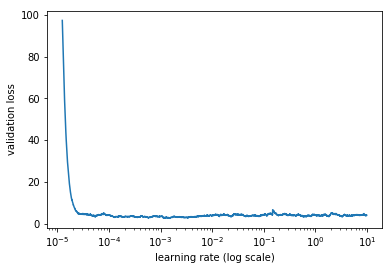

In [87]:
m.sched.plot(100)

In [ ]:
lr = 1e-4
m.fit(lr, 3, metrics=[score_metric])

In [ ]:
m.fit(lr, 2, metrics=[score_metric], cycle_len=4)

In [88]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_cols),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-4

In [89]:
m.fit(lr, 1, metrics=[score_metric])

epoch      trn_loss   val_loss   score_metric                  
    0      2.858336   2.671869   0.757988  



[2.6718691265596917, 0.7579881212826262]

In [ ]:
m.fit(lr, 3, metrics=[score_metric])

In [59]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_cols),
                    0.04, 1, [1000,500,250,125], [0.001,0.01,0.1,1], y_range=y_range)
lr = 1e-4

In [90]:
m.fit(lr, 5, metrics=[score_metric])

epoch      trn_loss   val_loss   score_metric                  
    0      2.798696   2.703397   0.750962  
    1      2.641934   2.67343    0.751494                      
    2      2.599395   2.744589   0.760759                      
    3      2.287228   2.7455     0.747689                      
    4      2.749346   2.823154   0.782294                      



[2.8231544078798527, 0.7822944729904794]

In [95]:
y=m.predict()

In [96]:
max(md.val_y)

array([22.88404], dtype=float32)

In [99]:
score_metric(y, md.val_y)

1.6802245

In [ ]:
pred_test=m.predict(True)

In [50]:
sub_df = pd.DataFrame({"fullVisitorId":test_df['fullVisitorId']})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_nn.csv", index=False)

In [37]:
m.save('val0')